# TP1a - Génération de variables aléatoires (Première partie)

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse à la génération de variables aléatoires, i.e., la capacité de produire des échantillons finis de variables ou vecteurs aléatoires d'une loi donnée. On suppose que l'on dispose d'un générateur de loi uniforme sur $[0,1]$ (avec Numpy, il est donné par $\texttt{np.random.rand}$). À partir de ce générateur, le but de ce TP sera de générer des échantillons d'autres lois, avec des méthodes simples, notamment la méthode de la *transformée inverse*. Des méthodes plus sophistiquées (acceptation-rejet, échantillonnage d'importance) seront présentées et étudiées à la séance suivante (après les vacances). Ce sera le sujet du TP-1b.

Pour chaque question, justifier la solution puis l'implémenter. Comparer avec la densité théorique à l'aide d'histogrammes ou de *kernel density estimates*.

### Instructions

1. Renommer votre notebook sous la forme `tp1a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 8 Novembre 2023, 23h59.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import seaborn as sns
import pandas as pd

### Partie 1 - Pour s'échauffer : lois uniformes

**Q1**. À partir de $N$ échantillons d'une loi uniforme sur l'intervalle $[0,1]$, comment obtenir $N$ échantillons d'une loi uniforme sur l'intervalle $[a,b]$ ?

On peut translater et scaler l'échantillon de loi uniforme sur $[0,1]$ pour obtenir un échantillon  d'une loi uniforme sur l'intervalle $[a,b]$

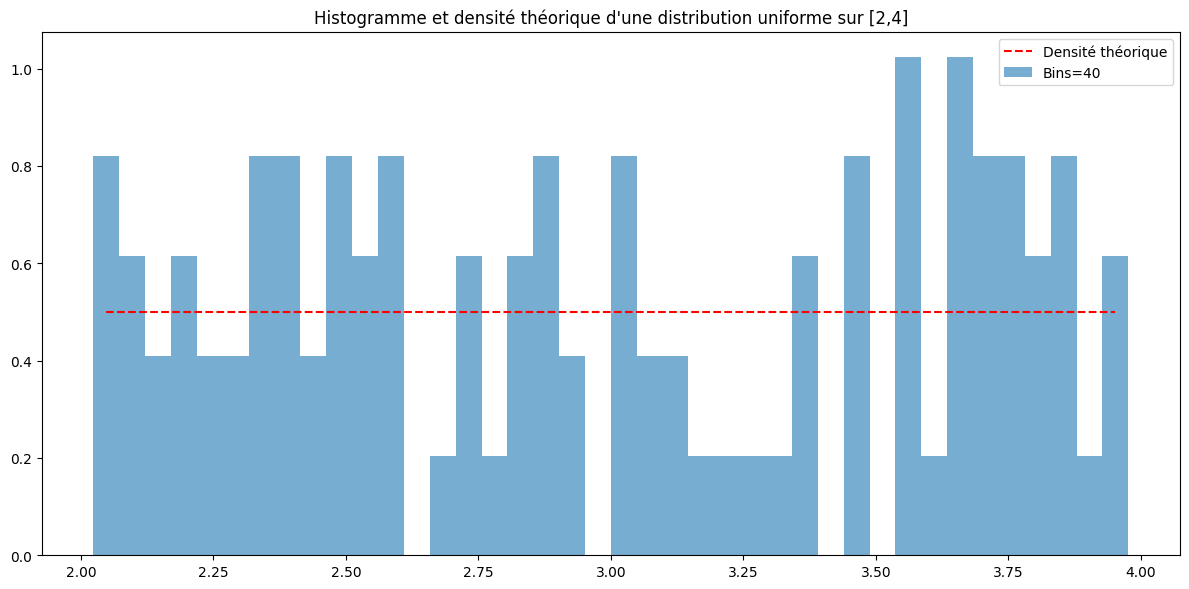

In [4]:
#####
N = 100
L = np.random.rand(N)
a,b = 2,4
L_ab = list(map(lambda x: x*(b-a)+ a, L))
Nb = 40

plt.figure(figsize=(12, 6))
hist, bins = np.histogram(L_ab, bins=Nb, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Theoritical density
density = np.full(Nb, 1 / (b - a))

plt.bar(bin_centers, hist, width=(bins[1] - bins[0]), alpha=0.6, label=f'Bins={Nb}')
plt.plot(bin_centers, density, 'r--', label='Densité théorique')
plt.title(f"Histogramme et densité théorique d'une distribution uniforme sur [{a},{b}]")
plt.legend()

plt.tight_layout()
plt.show()
#####

**Q2**. Comment obtenir $N$ échantillons d'une loi uniforme sur le pavé $[a,b] \times [c,d]$ ?

En utilisant la méthode précédente on peut générer des couples (x,y) suivant une loi uniforme sur le pavé $[a,b] \times [c,d]$

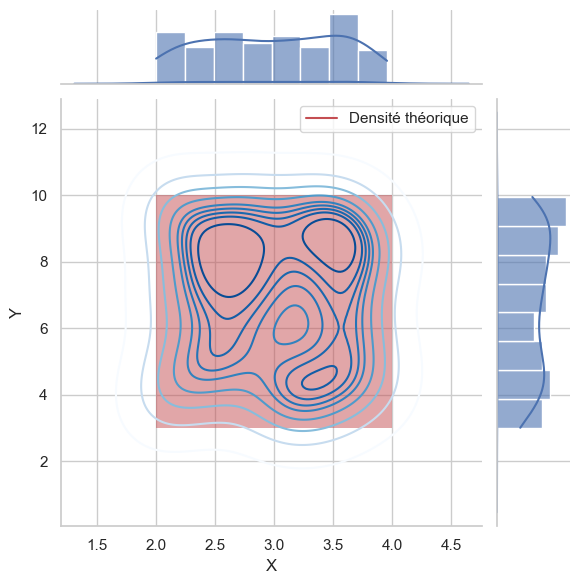

In [5]:
N = 100

a,b = 2,4
c,d = 3,10

Nb = 40

x_values = list(map(lambda x: x*(b-a)+ a, np.random.rand(N)))
y_values = list(map(lambda x: x*(d-c)+ c, np.random.rand(N)))

# Création d'un DataFrame pour seaborn
df = pd.DataFrame({'X': x_values, 'Y': y_values})

# Crée un graphique en nuage de points 2D avec densité estimée
sns.set(style="whitegrid")
g = sns.jointplot(x="X", y="Y", data=df, kind="kde", cmap="Blues")

# Dessine la zone de densité théorique
x_theoretical = np.linspace(a, b, 100)
y_theoretical = np.linspace(c, d, 100)
X, Y = np.meshgrid(x_theoretical, y_theoretical)
Z = np.ones_like(X) / ((b - a) * (d - c))

plt.contourf(X, Y, Z, colors='r', alpha=0.5)
g.plot_marginals(sns.histplot, color='b', alpha=0.6, kde=True)

plt.legend(handles=[plt.Line2D([0], [0], color='r', linestyle='-', label='Densité théorique')], loc="upper right")


plt.show()

**Q3**. À partir de $N$ échantillons de loi uniforme sur l'intervalle $[0,1]$, comment obtenir $N$ échantillon de loi uniforme discrète sur $\{1, ..., K\}$ ?

On utilise la méthode précende pour obtenir un échantillon d'une loi uniforme sur $[1,K]$ puis on discrétise en utilisant K bins centrés sur les valeurs $\{1, ..., K\}$

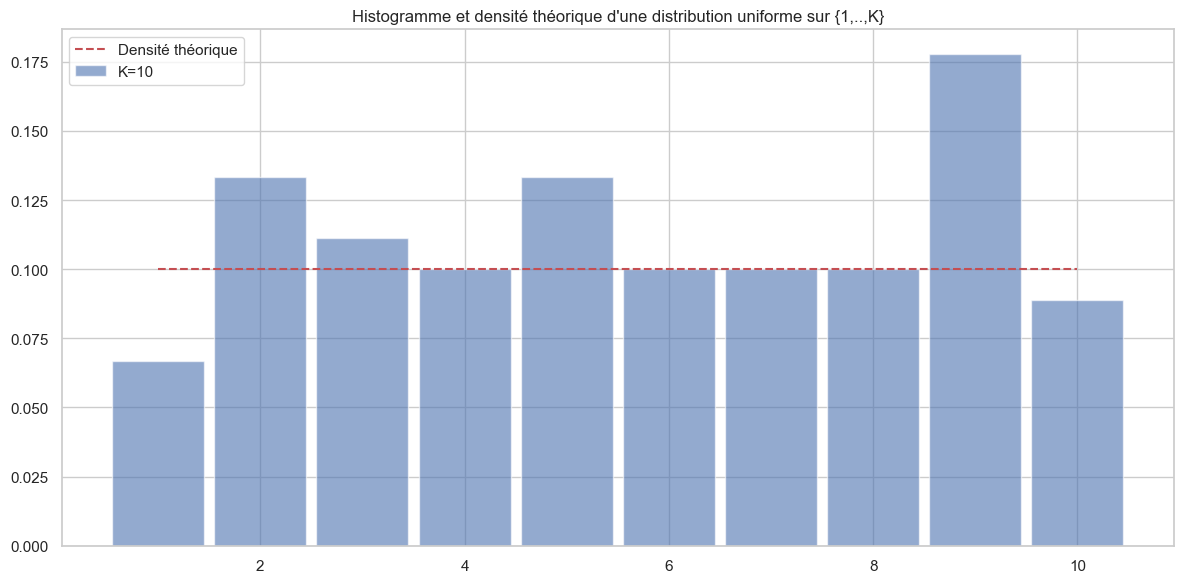

In [6]:
N = 100
L = np.random.rand(N)
k = 10
L_1_K = list(map(lambda x: np.floor(x*k)+ 1, L))


plt.figure(figsize=(12, 6))
hist, bins = np.histogram(L_1_K, bins=k, density=True)
bin_centers = np.linspace(1,10,10)

# Theoritical density
density = np.full(k, 1 /k)

plt.bar(bin_centers, hist, width=(bins[1] - bins[0]), alpha=0.6, label=f'K={k}')
plt.plot(bin_centers, density, 'r--', label='Densité théorique')
plt.title("Histogramme et densité théorique d'une distribution uniforme sur {1,..,K}")
plt.legend()

plt.tight_layout()
plt.show()

### Partie 2 - Méthode de la transformée inverse

Soit $X$ une variable aléatoire réelle de fonction de répartition $F$ (rappel : $F$ est une fonction croissante de $\mathbb{R}$ dans $[0,1]$, et "càdlàg", mais pas nécessairement bijective). On définit la **fonction inverse généralisée** $F^{-1}$ de $F$ par :
$$\forall~u \in [0,1], F^{-1}(u) = \inf\{x \in \mathbb{R}, F(x) \geq u\}.$$

Cette fonction conïncide avec l'inverse classique quand $F$ est bijective (attention même si $F$ est continue elle n'est pas nécessairement bijective, il peut y avoir des plateaux).

**Q1**. Montrer la proposition suivante :

Si $U$ suit la loi uniforme sur l'intervalle $[0,1]$, alors la v.a. $F^{-1}(U)$ a pour fonction de répartition $F$ (et donc la même loi que $X$).

Cela donne donc la méthode de la **transformée inverse** ; Si l'on connait explicitement la fonction $F^{-1}$, on peut simuler de n'importe quelle variable aléatoire à partir d'un échantillon de loi uniforme.

**Q2**. À l'aide de cette méthode, simuler $N$ échantillons d'une loi exponentielle de paramètre $\lambda$.

On détermine la fonction inverse généralisé d'une loi exponentiel. On l'applique ensuite à un échantillon généré à partir d'une loi uniform sur [0,1]

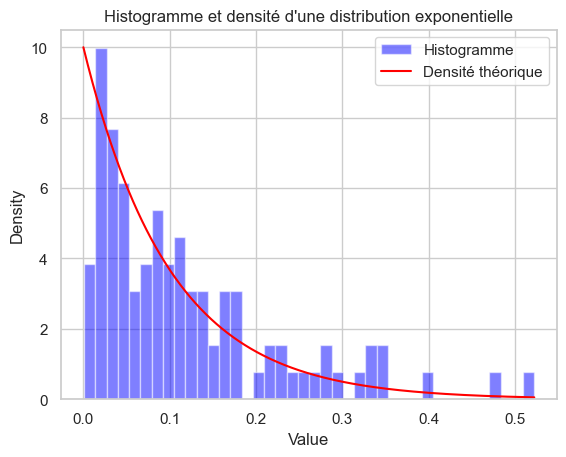

In [7]:
N = 100
# Expression de la fonction inverse généralisé d'une variable aléatoire suivant une loi exp de paramètre lb
exp_inverse = lambda u,ld: -1/ld*np.log(1-u) 
# Echantillon de loi normale
L = np.random.rand(N)
lambda_value = 10
L_exp = exp_inverse(L,lambda_value)

# Theoritical density
x = np.linspace(0, np.max(L_exp), 1000)
theoretical_density = lambda_value * np.exp(-lambda_value * x)

plt.hist(L_exp, bins=40, density=True, alpha=0.5, color='blue', label='Histogramme')

# Plot the theoretical density as a smooth curve
plt.plot(x, theoretical_density, color='red', label='Densité théorique')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title("Histogramme et densité d'une distribution exponentielle")
plt.show()

**Q3**. À l'aide de cette méthode, simuler $N$ échantillons d'une loi de Cauchy (standard, i.e. $x_0 = 0, a = 1$).

---- Votre réponse ici ----

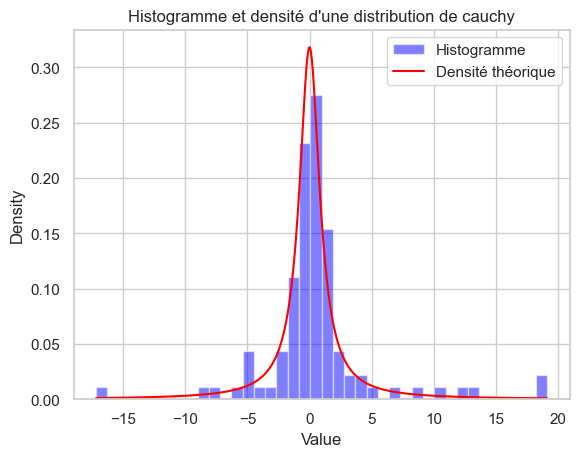

In [16]:
N = 100
# Expression de la fonction inverse généralisé d'une variable aléatoire suivant une loi de cauchy standard
cauchy_inverse = lambda u: np.tan(np.pi*u)
# Echantillon de loi normale
L = np.random.rand(N)

L_chauchy = cauchy_inverse(L)

# densité théorique
x = np.linspace( np.min(L_chauchy), np.max(L_chauchy), 1000)
theoretical_density = 1 / (np.pi * (1 + x**2))

plt.hist(L_chauchy, bins=40, density=True, alpha=0.5, color='blue', label='Histogramme')

plt.plot(x, theoretical_density, color='red', label='Densité théorique')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title("Histogramme et densité d'une distribution de cauchy")
plt.show()

**Q4**. Quelles sont les limitations de la méthode de la transformée inverse ?

La méthode de la transformé inverse nécessite d'avoir une expression explicite de la fonction inverse généralisé et dans le cas générale on ne sait pas faire ce calcul. Il faut alors passer par une résolution numérique de l'équation F(x) = u.

### Partie 3 - Transformation particulière : Méthode de Box-Müller

**Q1**. Soit $R \sim \text{Exp}(1/2)$ et $\Theta \sim U([0, 2 \pi])$ deux variables aléatoires indépendantes.

Montrer que $X = \sqrt{R} cos(\Theta)$ et $Y = \sqrt{R} sin(\Theta)$ sont deux variables indépendantes de loi $\mathcal{N}(0,1)$.

Cette méthode est connue comme la méthode de Box-Müller (1958), et est l'une des méthodes de référence pour générer des variables aléatoires normales.

----- Votre réponse ici -----

**Q2**. En déduire une façon de générer un $N$ échantillons de loi normale $\mathcal{N}(0,1)$ à partir d'échantillons d'une loi uniforme sur l'intervalle $[0,1]$.

On utilise la méthode de la transformé inverse pour générer un échantillon de loi exponentiel de paramêtre 1/2 à partir d'un premier échantillon de loi uniforme sur [0,1]. 
On génère ensuite une loi uniforme $U([0, 2 \pi])$ en utilisant un échantillon de loi uniforme $U([0, 1])$.
On applique pour finir la formule $X = \sqrt{R} cos(\Theta)$ pour obtenir l'échantillon voulu

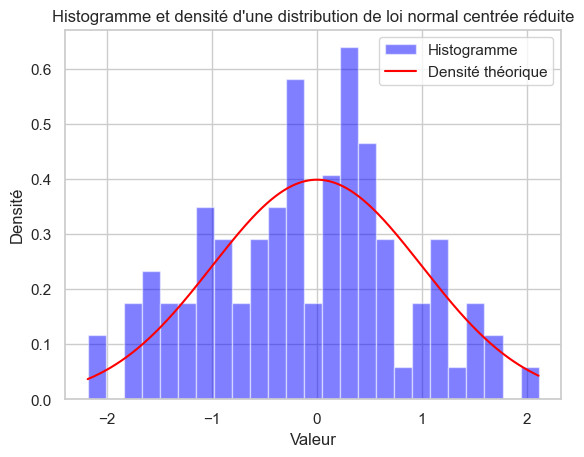

In [17]:
N = 100
# Expression de la fonction inverse généralisé d'une variable aléatoire suivant une loi exp de paramètre lb
exp_inverse = lambda u,ld: -1/ld*np.log(1-u) 
# Echantillon de loi normale pour générer un échantillon de loi exponentiel
L = np.random.rand(N)
lambda_value = 1/2
L_exp = exp_inverse(L,lambda_value)
# On génére un deuxième sample issue d'une distribution uniforme
L_uniform = np.random.rand(N)

# On obtient un échantillon d'une loi normale centrée réduite
L_norm = np.sqrt(L_exp)*np.cos(2*np.pi*L_uniform)

# densité théorique
x = np.linspace( np.min(L_norm), np.max(L_norm), 1000)
densite_th = 1 / (np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2)

plt.hist(L_norm, bins=25, density=True, alpha=0.5, color='blue', label='Histogramme')

plt.plot(x, densite_th, color='red', label='Densité théorique')

plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.legend()
plt.title("Histogramme et densité d'une distribution de loi normal centrée réduite")
plt.show()

**Q3**. À partir de $N$ échantillons de loi $\mathcal{N}(0,1)$, comment obtenir un $N$ échantillons de loi $\mathcal{N}(\mu, \sigma^2)$ ?

On sait que pour centrée et réduire une loi normale on soustré la moyenne et on divise par l'écart type. Donc on fait l'opération inverse pour généré une loi normale de moyenne mu et de variance sigma carré.

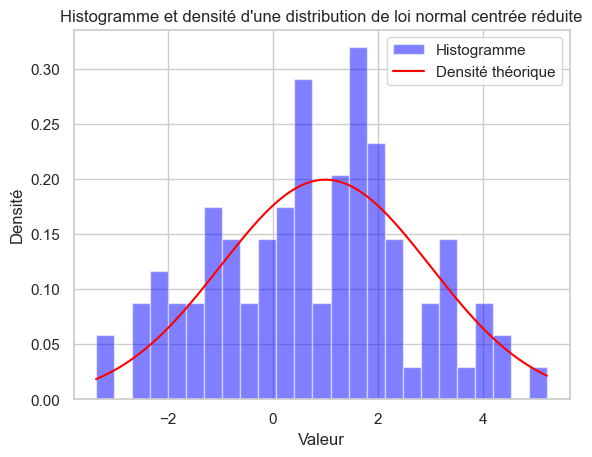

In [18]:
mu = 1
sigma = 2

L_mu_sigma = L_norm*sigma + mu

# Theoritical density
x = np.linspace( np.min(L_mu_sigma), np.max(L_mu_sigma), 1000)
densite_th = 1 / (np.sqrt(2 * np.pi)*sigma) * np.exp(-((x-mu)/sigma)**2 / 2)

plt.hist(L_mu_sigma, bins=25, density=True, alpha=0.5, color='blue', label='Histogramme')

# Plot the theoretical density as a smooth curve
plt.plot(x, densite_th, color='red', label='Densité théorique')

plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.legend()
plt.title("Histogramme et densité d'une distribution de loi normal centrée réduite")
plt.show()

**Q4**. On s'intéresse maintenant à la simulation d'un **vecteur** gaussien en dimension $d$.

Expliquer pourquoi la méthode de Box-Müller permet de simuler des vecteurs de loi $\mathcal{N_d}(\mathbf{0}_d, I_d)$.

Soit $X \sim \mathcal{N_d}(\mathbf{0}_d, I_d)$, $\mathbf{m} \in \mathbb{R}^d$, et $\boldsymbol{\Sigma} \in \mathbb{R}^{d \times d}$ symétrique définie positive. On suppose qu'il existe $\mathbf{L} \in \mathbb{R}^{d \times d}$ tel que $\boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^{\top}$. À l'aide des propriétés des vecteurs gaussiens, montrer que $Y = m + \mathbf{L}X \sim \mathcal{N_d}(\mathbf{m}, \boldsymbol{\Sigma})$.

La méthode de Box-Müller permet de générer des vecteurs de loi  $\mathcal{N_d}(\mathbf{0}_d, I_d)$ car il permet de générer des variables aléatoire de loi normal centrée réduite et en itérant le processus on obtient d variables aléatoires centrée-réduite indépendant et on obtient ainsi un vecteur suivant une loi $\mathcal{N_d}(\mathbf{0}_d, I_d)$

**Q5**. On peut montrer qu'une telle matrice $\mathbf{L}$ existe toujours. C'est la **décomposition de Cholesky** ($\mathbf{L}$ est triangulaire inférieure), qui est fondamentale en statistique et *machine learning*. Elle tire son nom d'André-Louis Cholesky, ingénieur polytechnicien, mort pendant la première guerre mondiale (résultat publié de manière posthume en 1924). À noter que le coût de calcul de cette décomposition est $\mathcal{O}(d^3)$ !

À partir de $N$ échantillons de loi $\mathcal{N_d}(\mathbf{0}_d, I_d)$, générer $N$ échantillons de loi $\mathcal{N_d}(\mathbf{m}, \boldsymbol{\Sigma})$. Prendre $d=2$ et utiliser $\texttt{np.linalg.cholesky}$.

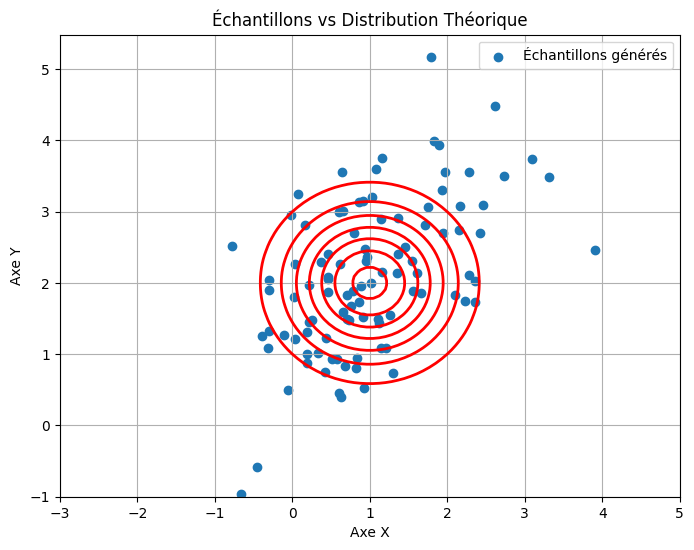

In [57]:
d = 2 
N = 100  
mean = np.array([1.0, 2.0])  
cov = np.array([[1.0, 0.5], [0.5, 1.0]])  

# Génération d'échantillons de loi N_d(0, I_d)
samples_standard = np.random.randn(N, d)

# Calcul de la décomposition de Cholesky de la matrice de covariance
cholesky_matrix = np.linalg.cholesky(cov)

# Transformation des échantillons en utilisant la décomposition de Cholesky
L_norm_d = samples_standard @ cholesky_matrix.T + mean

# Plot des échantillons
plt.figure(figsize=(8, 6))
plt.scatter(L_norm_d[:, 0], L_norm_d[:, 1], label='Échantillons générés')
plt.xlabel('Axe X')
plt.ylabel('Axe Y')

# Plot de la distribution théorique
x = np.linspace(-3, 5, 100)
y = np.linspace(-1, 5, 100)
X, Y = np.meshgrid(x, y)
theoretical_density = (1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * \
    np.exp(-0.5 * (X - mean[0])**2 * (cov[0, 0]**-1 + cov[1, 0] * cov[0, 1]**-1) - \
             0.5 * (Y - mean[1])**2 * (cov[1, 1]**-1 + cov[0, 1] * cov[0, 1]**-1))

plt.contour(X, Y, theoretical_density, levels = 7, colors='r', linewidths=2)
plt.legend()
plt.title('Échantillons vs Distribution Théorique')
plt.grid(True)
plt.show()

On observe que les échantillons suivent bien une distribution normale multivarié de moyenne défini par le vecteur mean et de matrice de covariance la matrice cov.